In [94]:
# inttatlize packages
from viresclient import set_token
from viresclient import SwarmRequest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
#import mplcyberpunk
from itertools import chain
import pickle
from scipy.fft import fft, fftfreq
import asilib
import asilib.asi
import cdflib
import xarray
import resampy
from scipy import signal

Set Token

Token saved for https://vires.services/ows


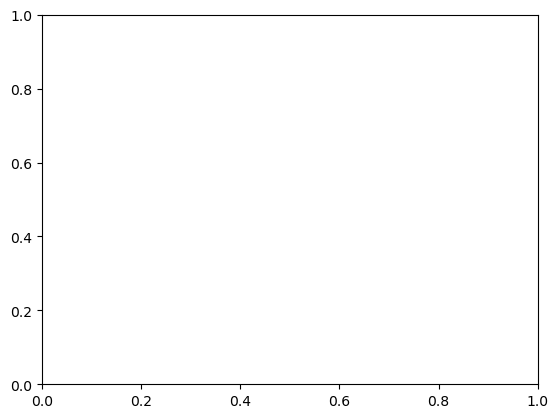

In [95]:
# Set key for getting data
set_token(
    "https://vires.services/ows",
    set_default=True,
    token="kmxv5mTTyYwzw4kQ9lsCkGfQHtjjJRVZ",
)  # key
# plt.style.use("cyberpunk")  # Dark mode!
plt.ticklabel_format(axis="y", style="scientific")

Set Time 

In [125]:
time_range = (datetime(2021, 3, 7, 8, 17), datetime(2021, 3, 7, 8, 22)) 

In [126]:
def numpy_conditioning(array):
    print(len(array))
    array_returned=np.zeros((len(array),3))
    for i in range(len(array)):
        for j in range(3):
            array_returned[i][j]=array[i][j]
    return array_returned


Get data

In [127]:
Magnetic_products = "SW_OPER_MAGB_LR_1B"
request = SwarmRequest()
request.set_collection(Magnetic_products)
request.set_products(
    measurements=["B_NEC", "Flags_B"],
    models=["CHAOS"],
    residuals=False,  # grabs residual from chaos
)
data = request.get_between(
    start_time=time_range[0],
    end_time=time_range[1],
    asynchronous=False,
)
# changes data into a dataframe format, which is easy to use
df_b = data.as_dataframe()
print(np.shape(df_b["B_NEC"].to_numpy()))
B_NEC = numpy_conditioning(df_b["B_NEC"].to_numpy()) * 10 ** (-9)
B_CHAOS = numpy_conditioning(df_b["B_NEC_CHAOS"].to_numpy()) * 10 ** (-9)
B_RES = B_NEC - B_CHAOS
print(df_b["Flags_B"])
if any(df_b["Flags_B"]):
    raise ValueError("Bad data")
else:
    pass

Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.071MB)


(300,)
300
300
Timestamp
2021-03-07 08:17:00    0
2021-03-07 08:17:01    0
2021-03-07 08:17:02    0
2021-03-07 08:17:03    0
2021-03-07 08:17:04    0
                      ..
2021-03-07 08:21:55    0
2021-03-07 08:21:56    0
2021-03-07 08:21:57    0
2021-03-07 08:21:58    0
2021-03-07 08:21:59    0
Name: Flags_B, Length: 300, dtype: uint8


Get E data


In [128]:
Electric_products = "SW_EXPT_EFIB_TCT16"
request = SwarmRequest()
request.set_collection(Electric_products)
request.set_products(
    measurements=[
        "Ehx",
        "Ehy",
        "Ehz",
        "VsatN",
        "VsatE",
        "VsatC",
        "Calibration_flags",
        "Quality_flags",
    ],
)
data = request.get_between(
    start_time=time_range[0],
    end_time=time_range[1],
    asynchronous=False,
)
# changes data into a dataframe format, which is easy to use
df_E = data.as_dataframe()
length_of_timeseries = len(df_E)

time_array_E = df_E["Spacecraft"].index

# E derived from the horizontal sensor
E_data_numpy = df_E[["Ehx", "Ehy", "Ehz"]].to_numpy() * 0.001
V_data_numpy = df_E[["VsatN", "VsatE", "VsatC"]].to_numpy()
E_data = numpy_conditioning(E_data_numpy)
print(E_data)
Velocity = numpy_conditioning(E_data_numpy)
for col in df_E.columns:
    print(col)

Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.262MB)

4800
[[-0.00657994 -0.00112857 -0.00326981]
 [-0.00830258  0.00322322 -0.003039  ]
 [-0.00579939 -0.00213062 -0.00314836]
 ...
 [ 0.00992913 -0.00100078  0.00752765]
 [ 0.01111733 -0.00427964  0.0075626 ]
 [ 0.01073212 -0.00796412  0.00624973]]
4800
Spacecraft
Quality_flags
VsatN
Calibration_flags
Latitude
Ehy
Radius
Longitude
Ehx
VsatC
VsatE
Ehz


Lets check the Quality of the data

In [129]:
"""
if any(df_E["Calibration_flags"]):
    np.savetxt("Calibration.csv", df_E["Calibration_flags"])
    raise ValueError("Bad Calibration")
elif any(df_E["Quality_flags"]):
    np.savetxt("Quality.csv", df_E["Quality_flags"])
    raise ValueError("Bad Quality")
else:
    pass
"""

'\nif any(df_E["Calibration_flags"]):\n    np.savetxt("Calibration.csv", df_E["Calibration_flags"])\n    raise ValueError("Bad Calibration")\nelif any(df_E["Quality_flags"]):\n    np.savetxt("Quality.csv", df_E["Quality_flags"])\n    raise ValueError("Bad Quality")\nelse:\n    pass\n'

Find V unit vector so we can get E in the right coordinate system


In [130]:
VelocitySum = np.abs(Velocity).sum(axis=1)
Velocity_Unit = Velocity / VelocitySum[:, np.newaxis]
ElectricNEC = np.multiply(Velocity_Unit, E_data)
print(ElectricNEC)

[[3.94373407e-03 1.16017117e-04 9.73889787e-04]
 [4.73284098e-03 7.13303606e-04 6.34097993e-04]
 [3.03590862e-03 4.09765411e-04 8.94733706e-04]
 ...
 [5.34131424e-03 5.42626817e-05 3.07004152e-03]
 [5.38315637e-03 7.97720435e-04 2.49102985e-03]
 [4.61711020e-03 2.54258635e-03 1.56574930e-03]]


We need to resample E data into 1hz instead of 2hz

In [131]:

ElectricNEC_resample = np.empty((int(len(ElectricNEC)/16), 3))
print(np.shape(ElectricNEC_resample))
for i in range(3):
    ElectricNEC_resample[:, i] = resampy.resample(ElectricNEC[:, i], 16, 1)

(300, 3)


Change both to the correct coordinate system (MFA)

In [132]:
def Coordinate_change(lattiude, longitude, radius):  # Coordinate change
    a, b, e2 = 6378137.0, 6356752.3142, 0.00669437999014  # From GRS80
    lat, lon, h = lattiude, longitude, radius
    v = a / np.sqrt(1 - e2 * np.sin(lat) * np.sin(lat))  # logic
    x = (v + h) * np.cos(lat) * np.cos(lon)
    y = (v + h) * np.cos(lat) * np.sin(lon)
    z = (v * (1 - e2) + h) * np.sin(lat)
    return [x, y, z]

In [133]:
from MFA_code import MFA
import pymap3d as pymap
time_array_b = df_b["Spacecraft"].index
# Since time array is one hertz and we want to look for 1/cadence hertz we simply use
lattiude = df_b["Latitude"].to_numpy()
longitude = df_b["Longitude"].to_numpy()
radius = df_b[
    "Radius"
].to_numpy()  # TODO check if I should be modifiying radius at all or if it should be from centre of the Earth

#r_nec = Coordinate_change(
#    lattiude, longitude, radius
#)  # Change these geo coordinates to NEC coordinates
#r_nec_pymap = pymap.ae(lattiude, longitude, h, lat0, lon0, h0)
BMFA = MFA(B_RES, B_CHAOS,None)
EMFA = MFA(ElectricNEC_resample, B_CHAOS,None)

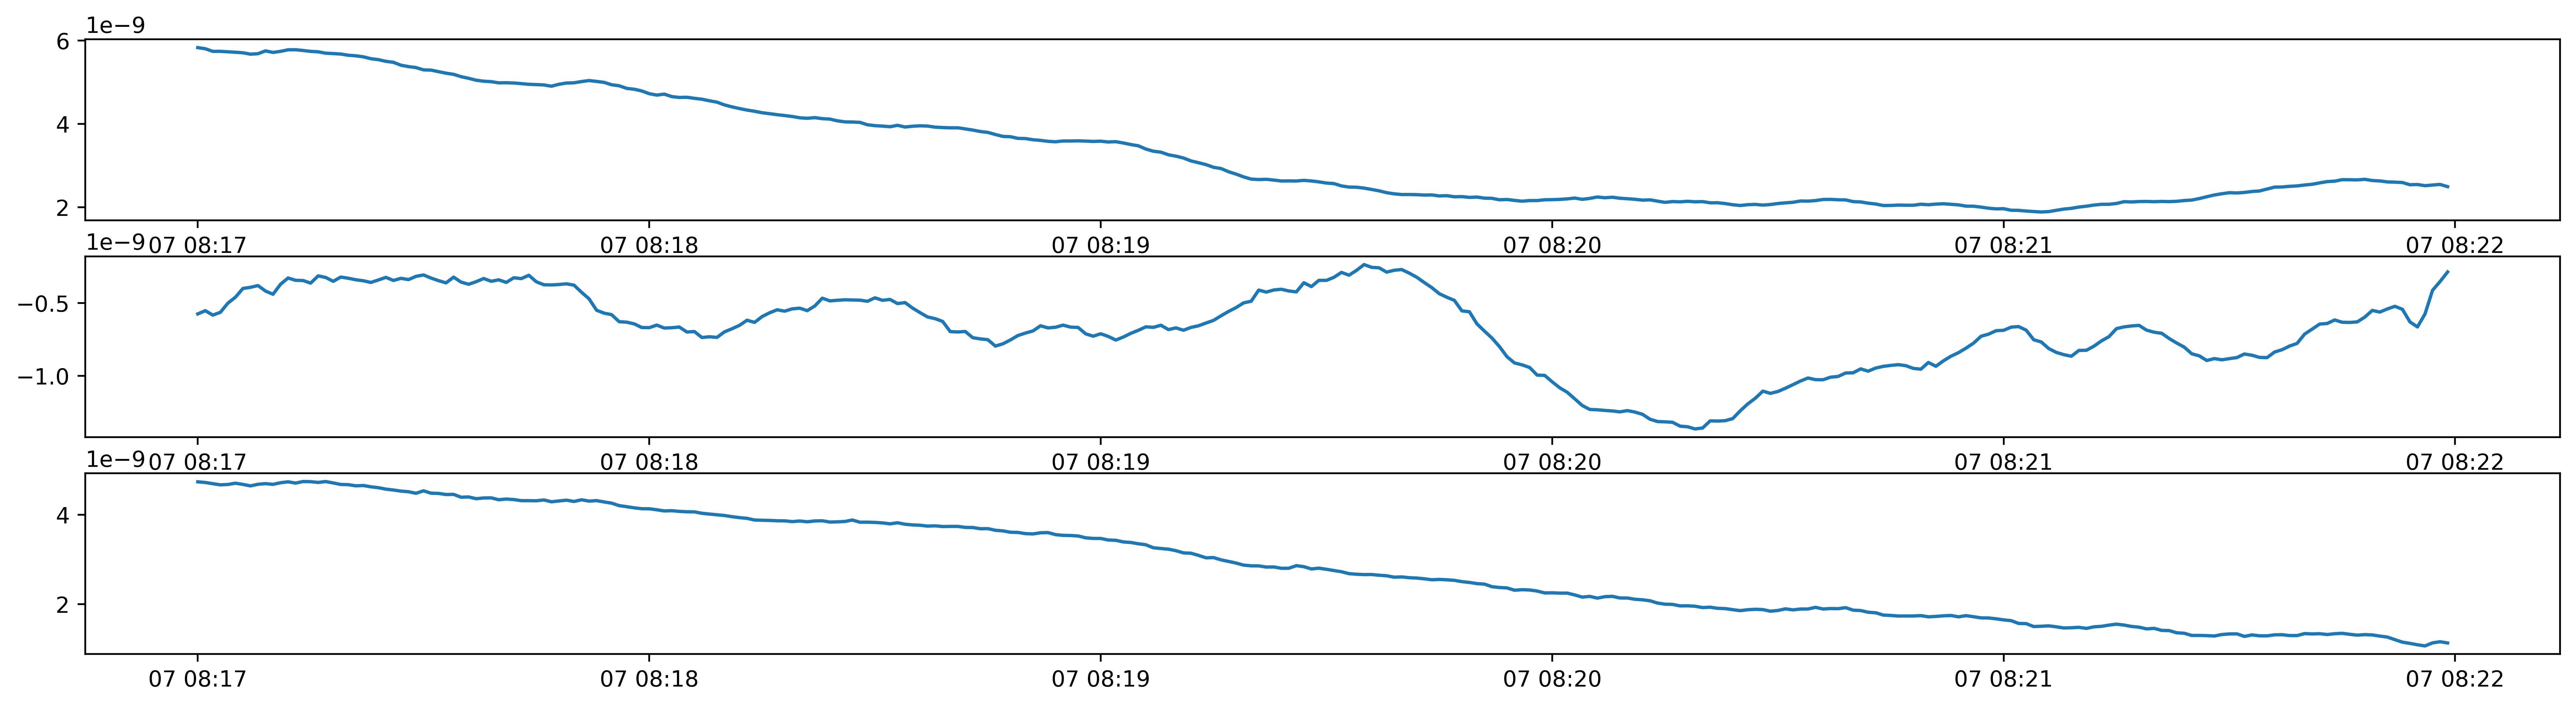

In [134]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=3, dpi=500)
for i in range(3):
    axes[i].plot(time_array_b, B_RES[:, i])
plt.show()

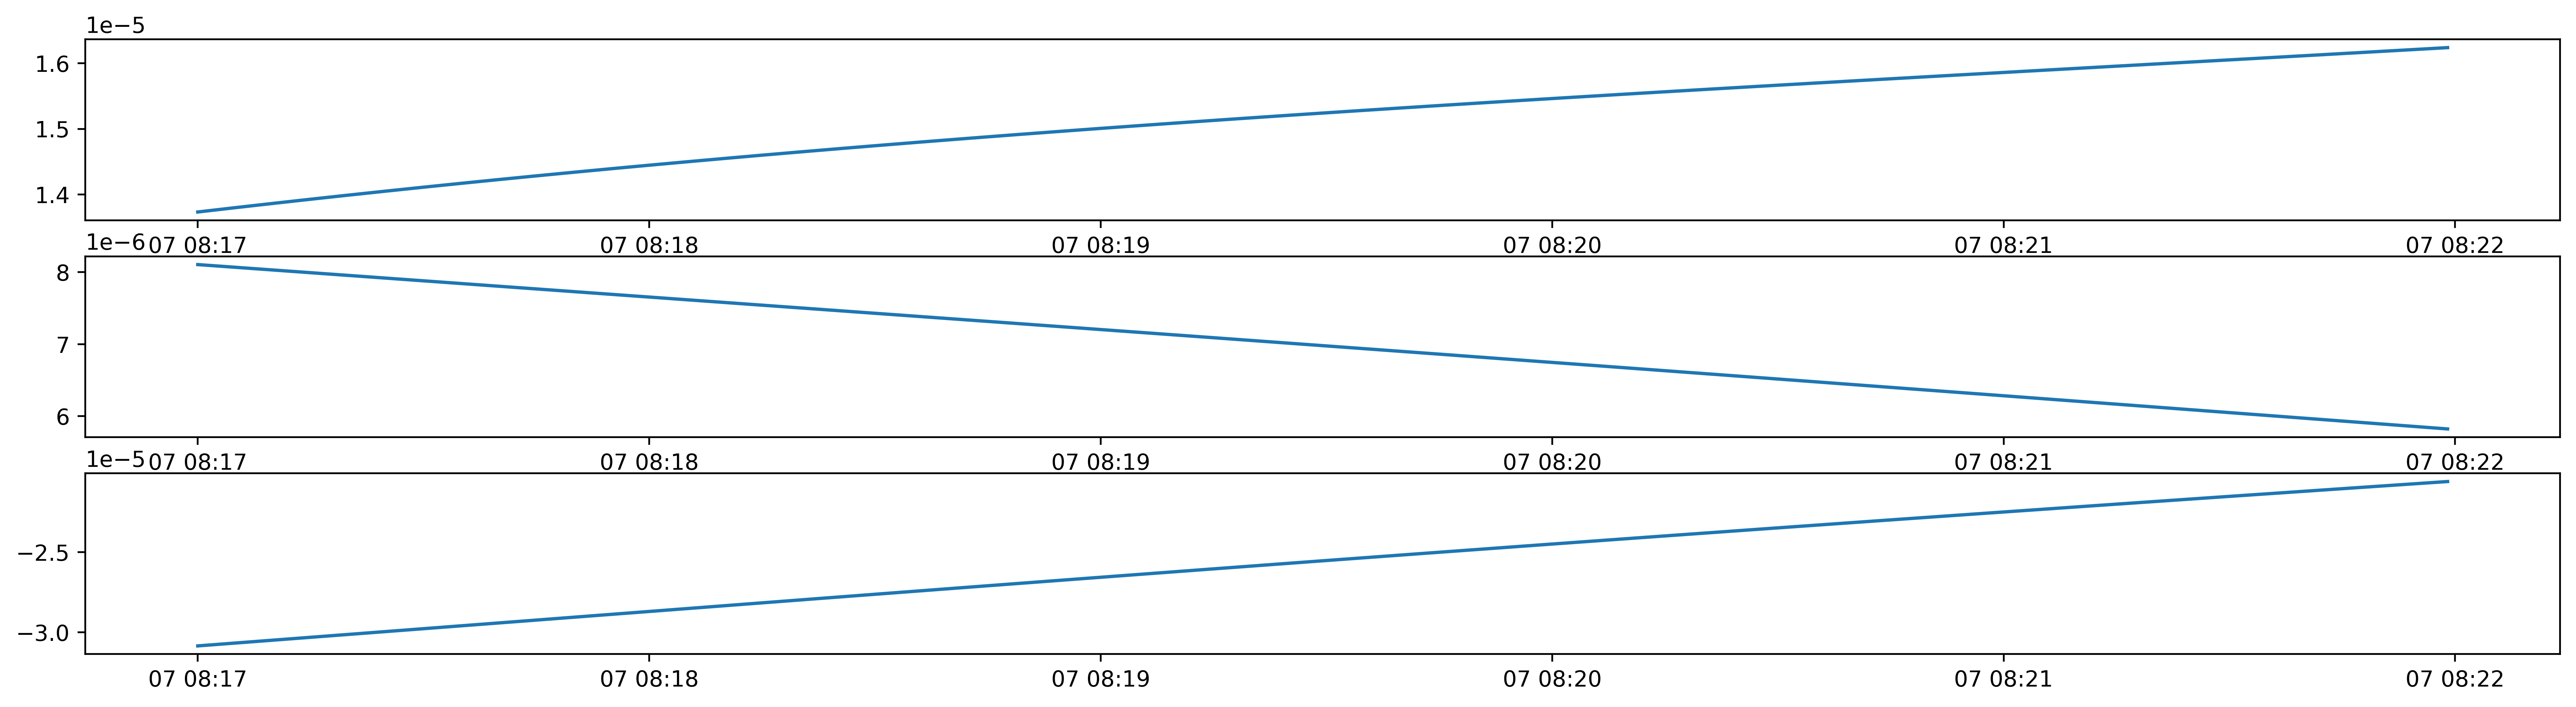

In [135]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=3, dpi=500)
for i in range(3):
    axes[i].plot(time_array_b, B_CHAOS[:, i])
plt.show()

Lets Plot some stuff for sanity checks

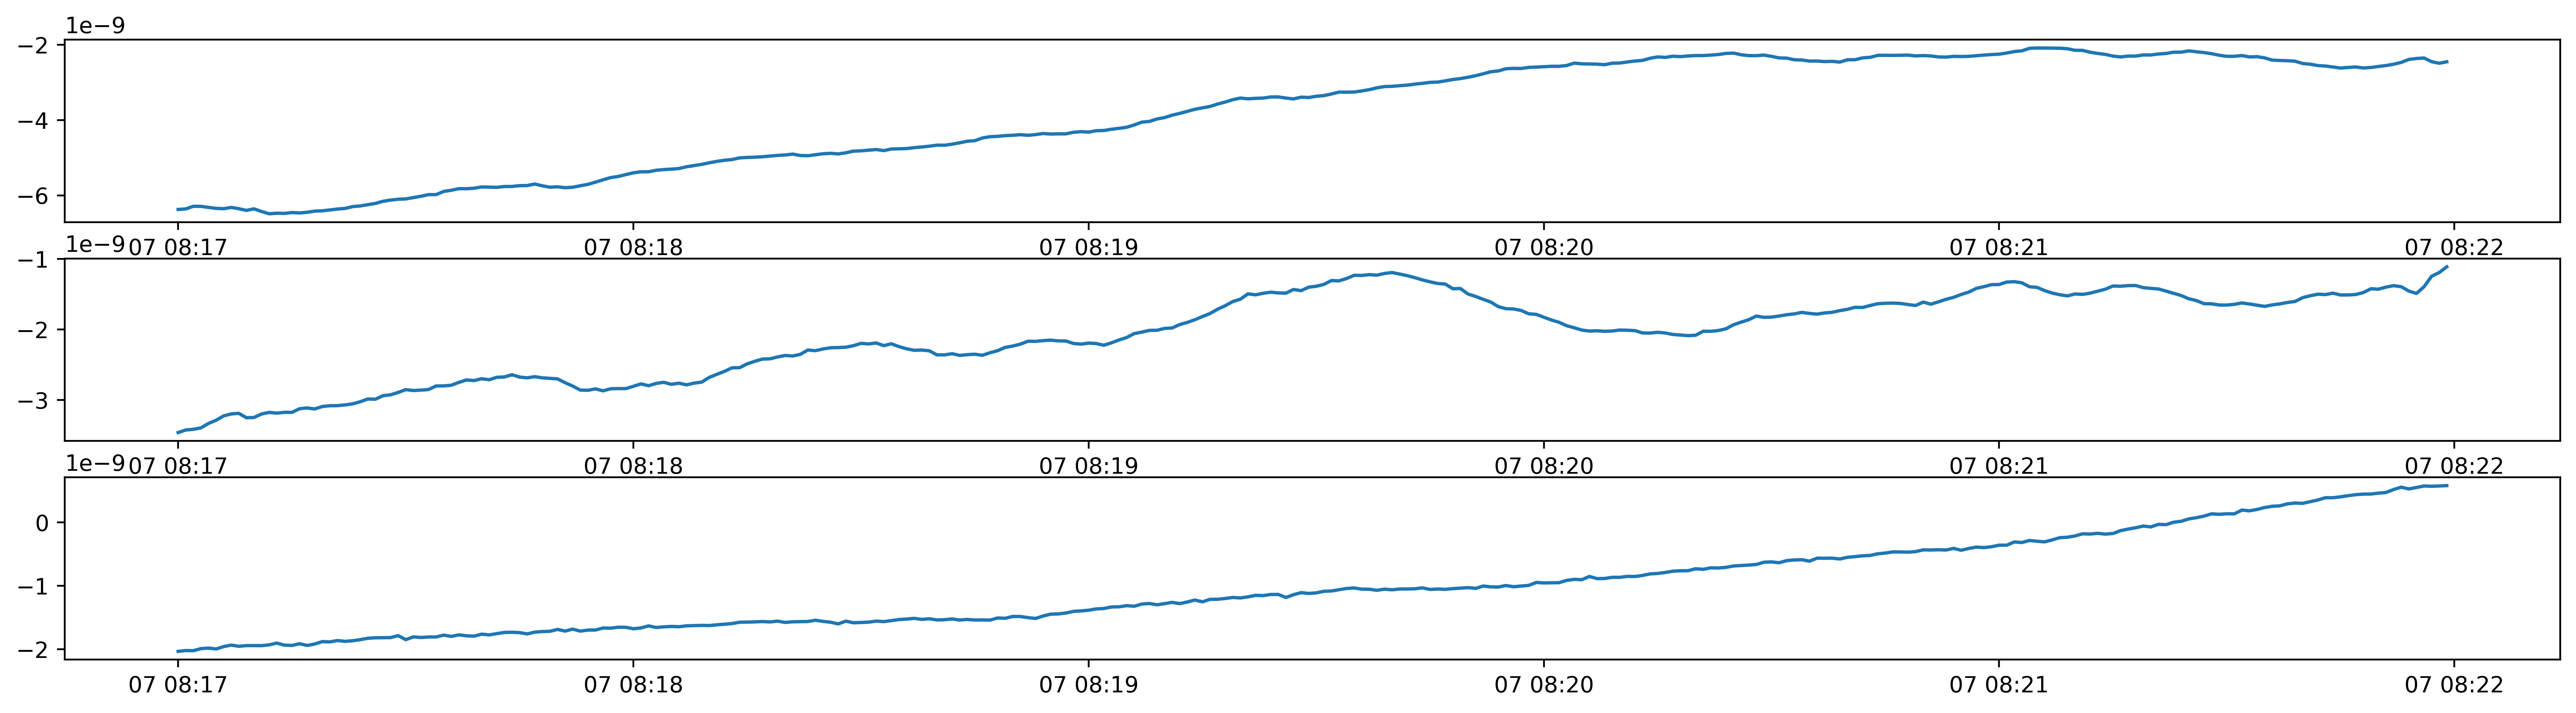

In [136]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=3, dpi=500)
for i in range(3):
    axes[i].plot(time_array_b, BMFA[:,i])
plt.show()

[0.00394373 0.00473284 0.00303591 ... 0.00534131 0.00538316 0.00461711]
[1.16017117e-04 7.13303606e-04 4.09765411e-04 ... 5.42626817e-05
 7.97720435e-04 2.54258635e-03]
[0.00097389 0.0006341  0.00089473 ... 0.00307004 0.00249103 0.00156575]


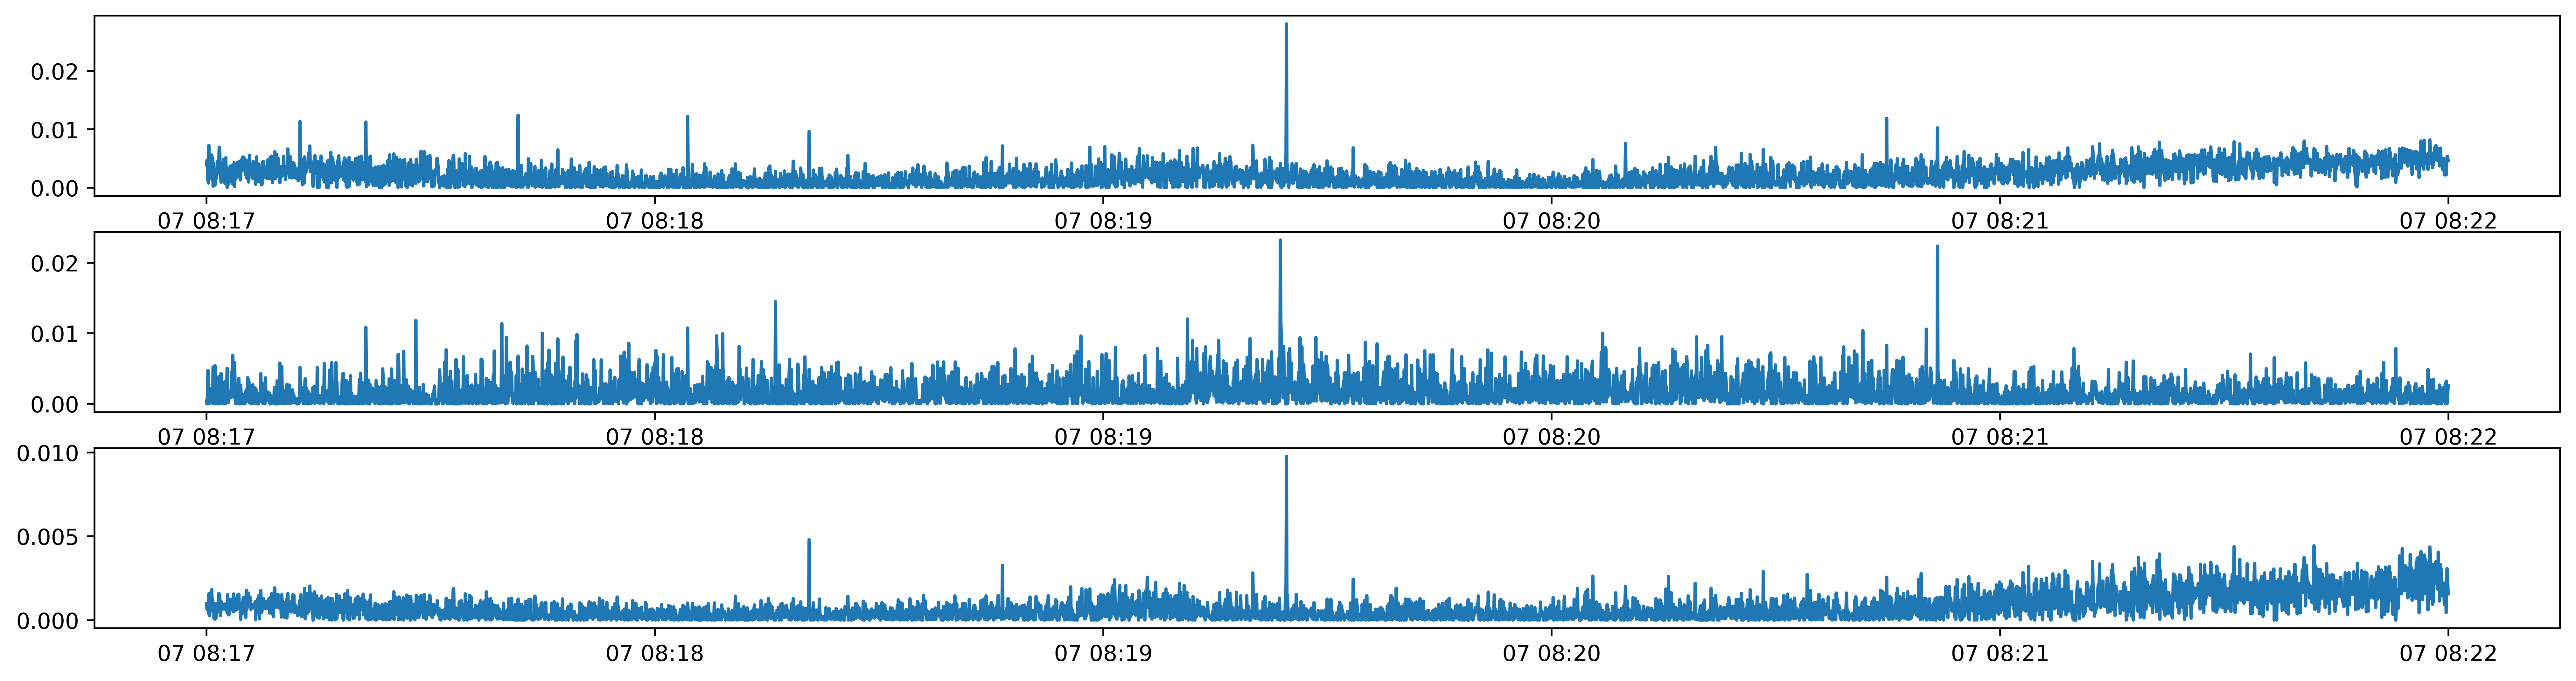

In [137]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=3, dpi=500)
for i in range(3):
    axes[i].plot(time_array_E, ElectricNEC[:,i])
    print(ElectricNEC[:,i])
plt.show()

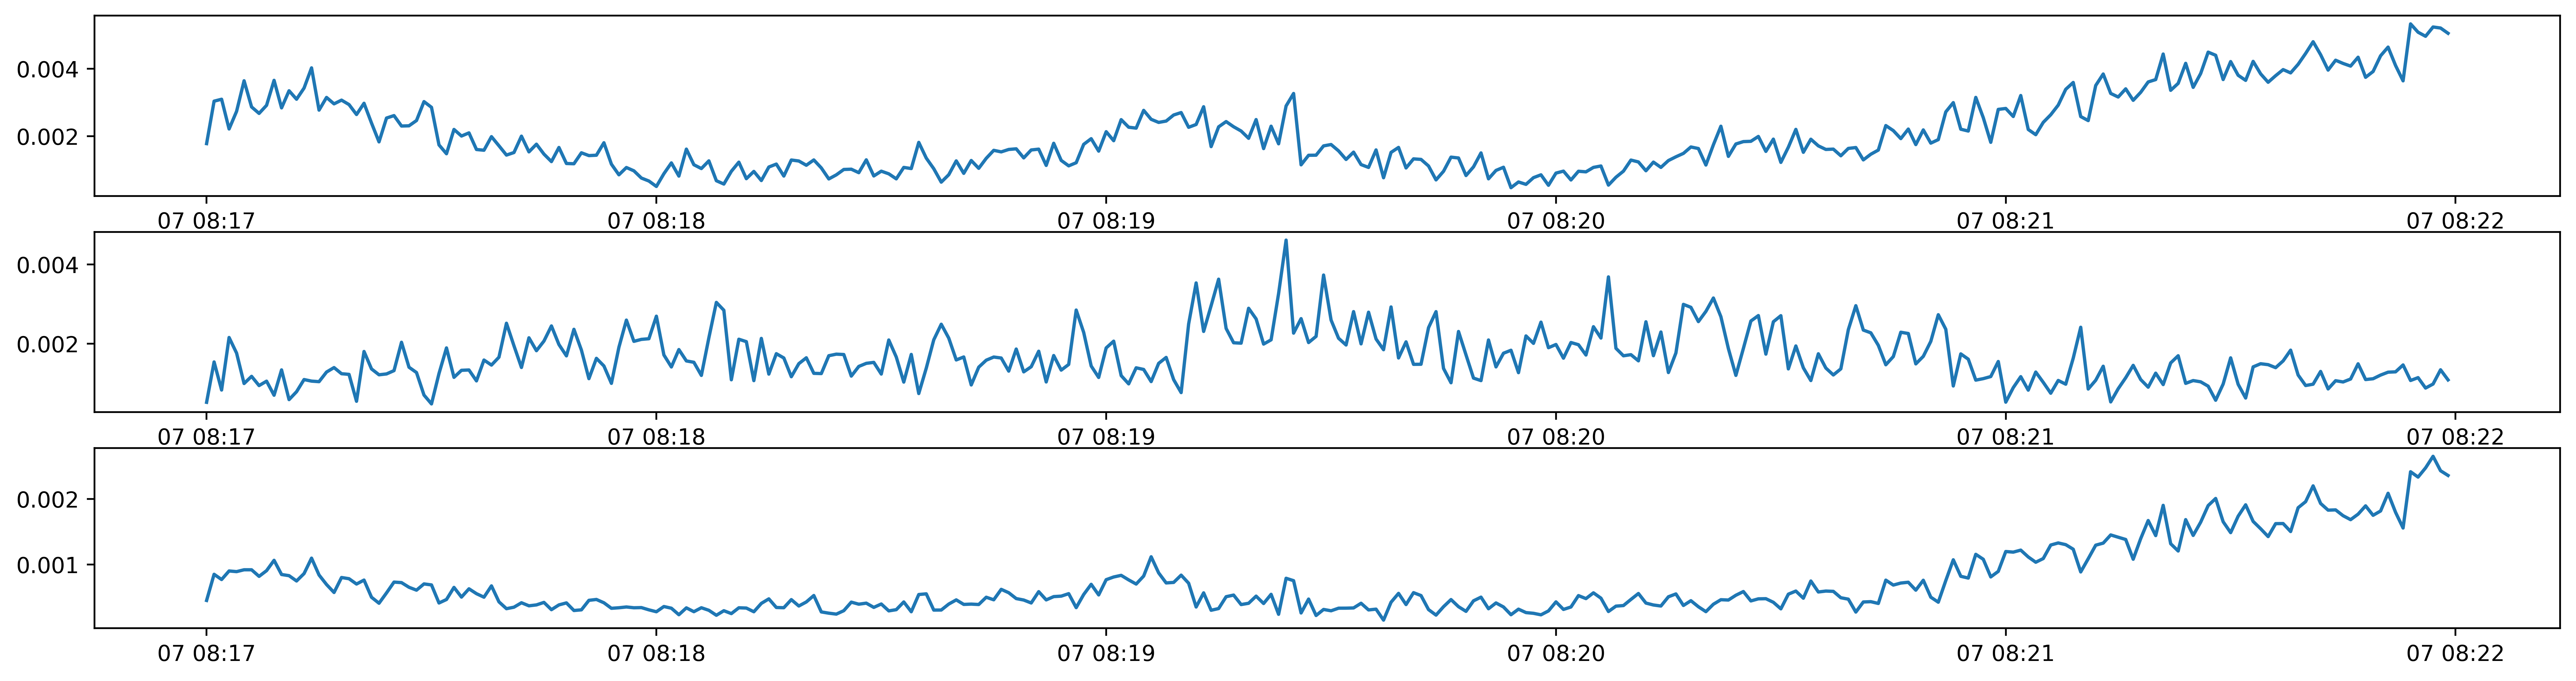

In [138]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=3, dpi=500)
for i in range(3):
    axes[i].plot(time_array_b, ElectricNEC_resample[:, i])
plt.show()

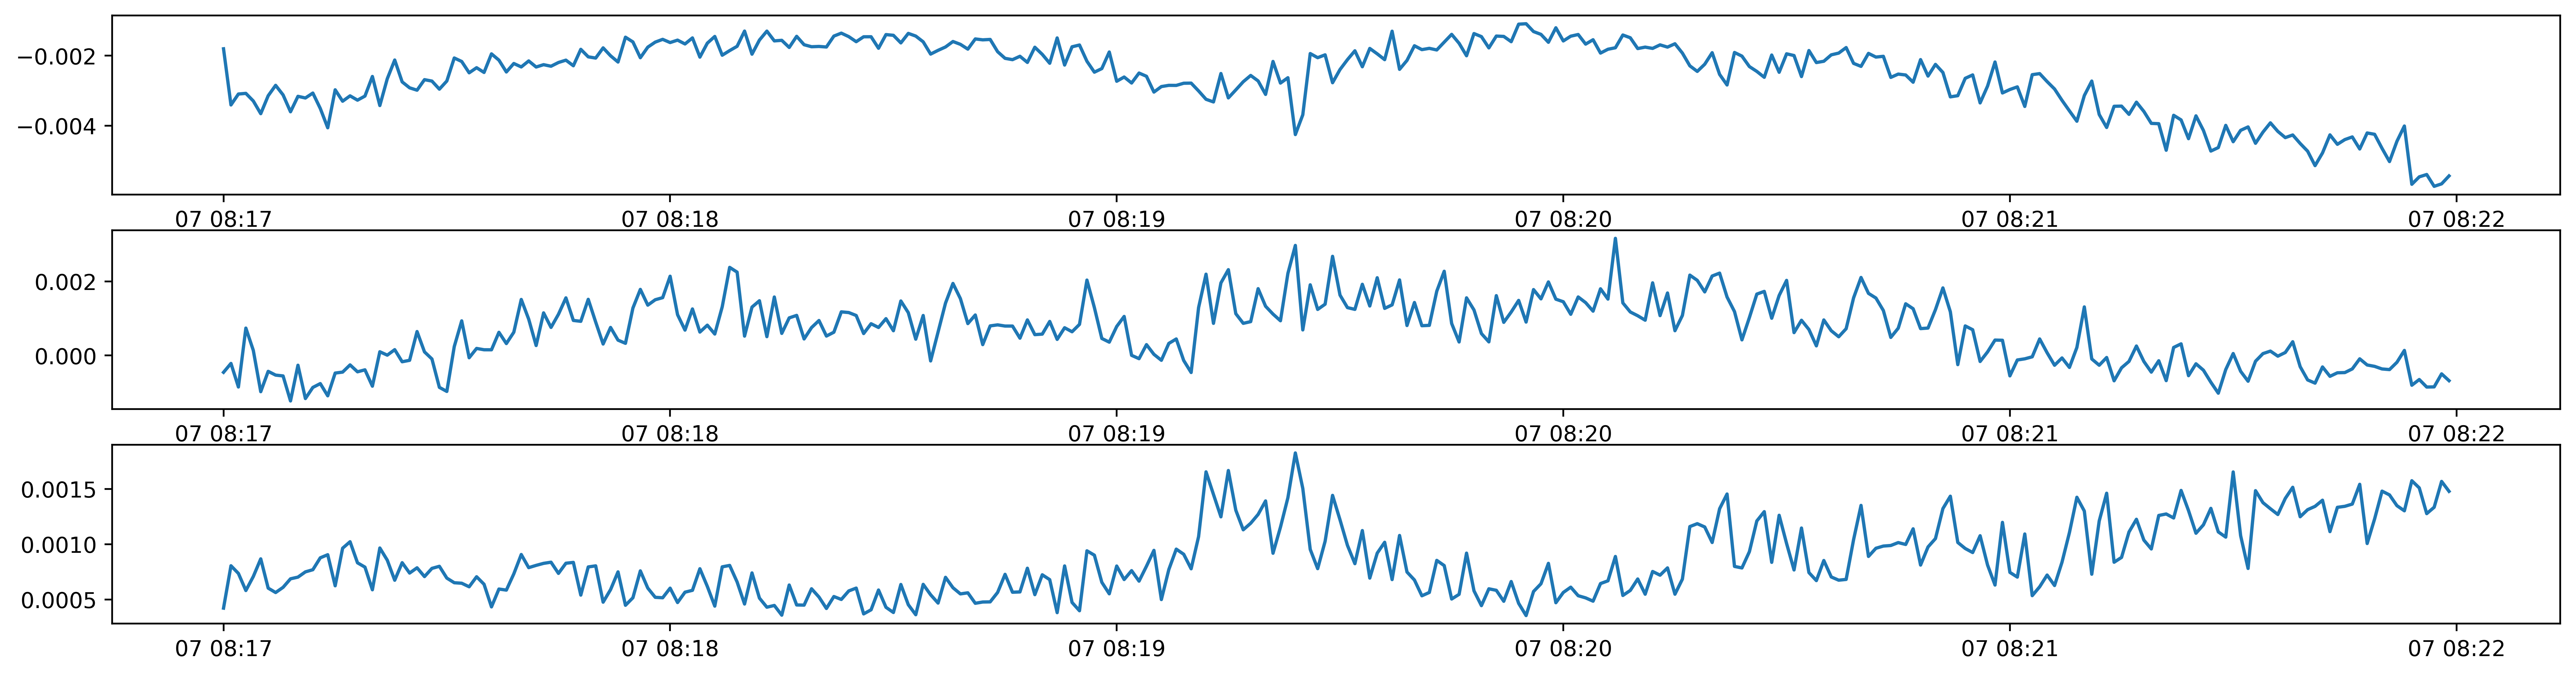

In [139]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=3, dpi=500)
for i in range(3):
    axes[i].plot(time_array_b,EMFA[:, i])
plt.show()

Now lets Start doing some Bayseian stuff

The equation we will be using is 

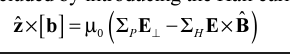

where b is the magnetic field in the MFA direction. In the MFA coordinate system, we get 1 equation in each direction.

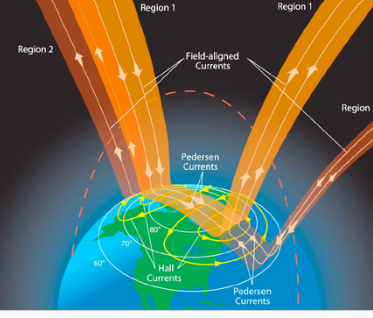

In [140]:
import pymc as pm
from scipy.constants import mu_0

B_MFA_hat = [0, 0, 1]
LHS = np.cross([0, 0, 1], BMFA)
print(EMFA[:, 1]*1000)
with pm.Model() as time_varying_model_hall:
    mean=pm.Normal("mean")
    std=pm.Normal("std")
    hall = pm.GaussianRandomWalk("epsilon_h",mu=mean,sigma=std, shape=len(time_array_b))
    outcome_azi = pm.Normal("outcome_azi", mu=hall, observed=LHS[:,1]/(-mu_0*EMFA[:,0]))

[-0.45459627 -0.2143421  -0.85128289  0.74113579  0.13950093 -0.97823177
 -0.42814917 -0.53003142 -0.55251196 -1.22864572 -0.26318187 -1.1638236
 -0.86337227 -0.75960347 -1.08993788 -0.47495595 -0.44853112 -0.25397354
 -0.44064184 -0.38722636 -0.82931716  0.10142391  0.00998252  0.15819153
 -0.16886051 -0.12961918  0.6480293   0.09801636 -0.0937081  -0.86132042
 -0.97143356  0.24273049  0.93714667 -0.06039003  0.19146527  0.15547669
  0.15464702  0.62734827  0.32327117  0.63007004  1.51581448  0.98310981
  0.27033122  1.1531775   0.75996122  1.11546241  1.55914798  0.9487811
  0.92467605  1.51943929  0.90424738  0.31091305  0.75874967  0.41589996
  0.32984295  1.28269732  1.78803253  1.36245924  1.50810779  1.56485049
  2.14425084  1.10411036  0.687332    1.25927719  0.63410015  0.8205268
  0.58104554  1.31700392  2.3836451   2.25498331  0.52489162  1.30921497
  1.48151551  0.5100926   1.58205223  0.59839502  1.01767462  1.0851085
  0.44805459  0.75565068  0.94645368  0.52637819  0.630

c:\Users\1101w\anaconda3\envs\pymc_env\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [141]:
n_samples=2000
n_tune=1000
with time_varying_model_hall:
    trace = pm.sample(
        n_samples,
        tune=n_tune,
        return_inferencedata=False,
        target_accept=0.99,
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std, epsilon_h]


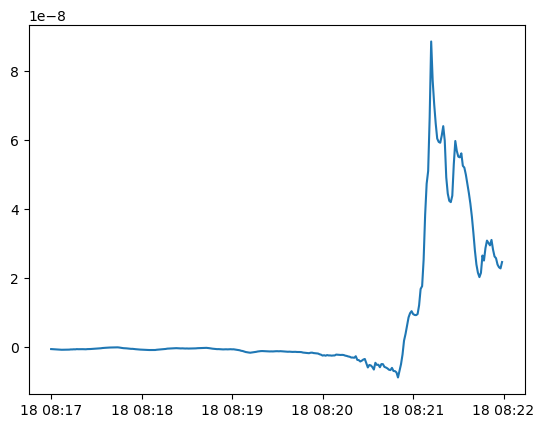

In [ ]:
plt.plot(time_array_b, LHS[:, 1])

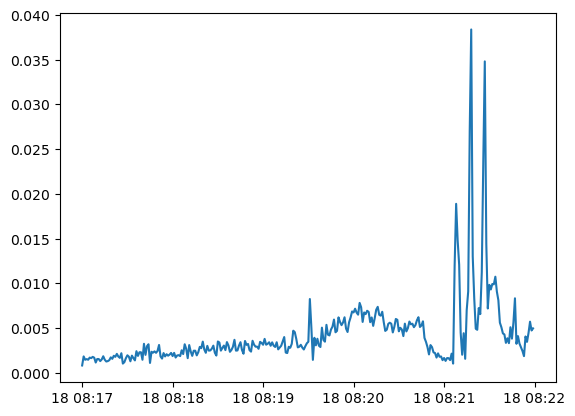

In [ ]:
plt.plot(time_array_b, EMFA[:, 0])

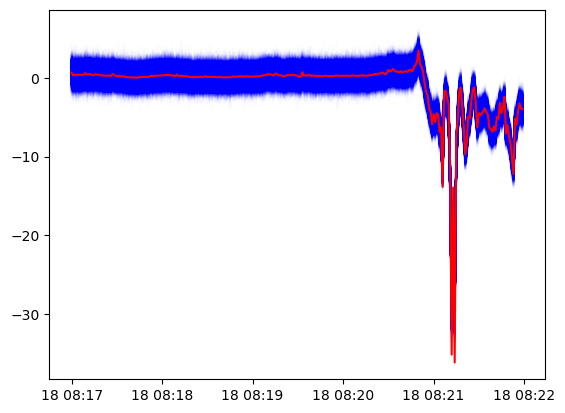

In [ ]:
plt.plot(time_array_b, trace["epsilon_h"].T, color="blue", alpha=0.01)
plt.plot(time_array_b, LHS[:, 1] / (-mu_0 * EMFA[:, 0]), color="red")

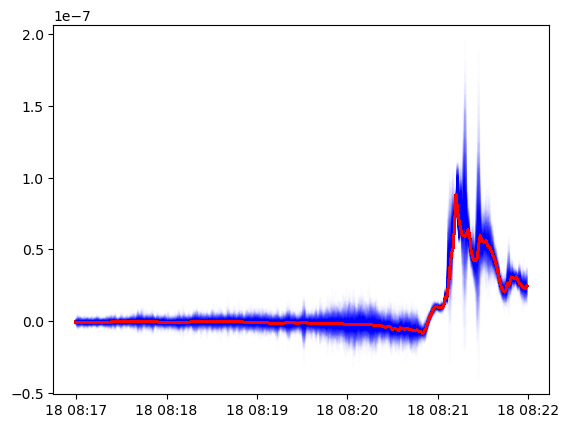

In [ ]:
for i in range (len(trace["epsilon_h"].T)):
    plt.plot(time_array_b, trace["epsilon_h"].T[:,i]*-mu_0*EMFA[:,0],color='blue', alpha=0.01)
    plt.plot(time_array_b, LHS[:,1], color='red')

In [ ]:
with pm.Model() as time_varying_model_pederson:
    mean = pm.Normal("mean")
    std = pm.Normal("std")
    hall = pm.GaussianRandomWalk(
        "epsilon_p", mu=mean, sigma=std, shape=len(time_array_b)
    )
    outcome_azi = pm.Normal(
        "outcome_azi", mu=hall, observed=LHS[:, 0] / (-mu_0 * EMFA[:, 1])
    )

c:\Users\1101w\anaconda3\envs\pymc_env\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [ ]:
n_samples = 2000
n_tune = 1000
with time_varying_model_pederson:
    trace = pm.sample(
        n_samples,
        tune=n_tune,
        return_inferencedata=False,
        target_accept=0.99,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std, epsilon_p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.


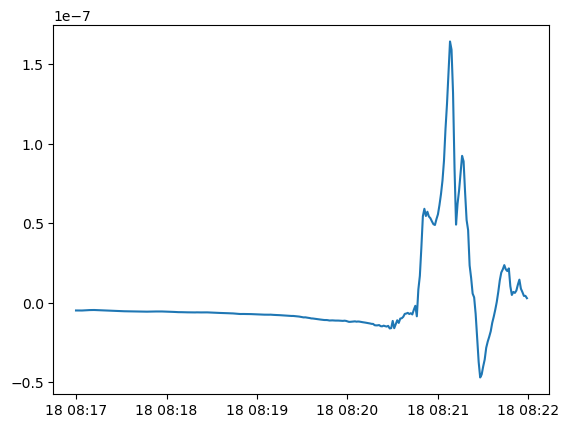

In [ ]:
plt.plot(time_array_b, LHS[:, 0])

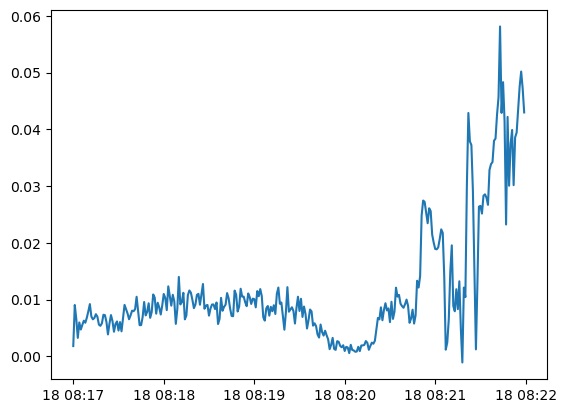

In [ ]:
plt.plot(time_array_b, EMFA[:, 1])

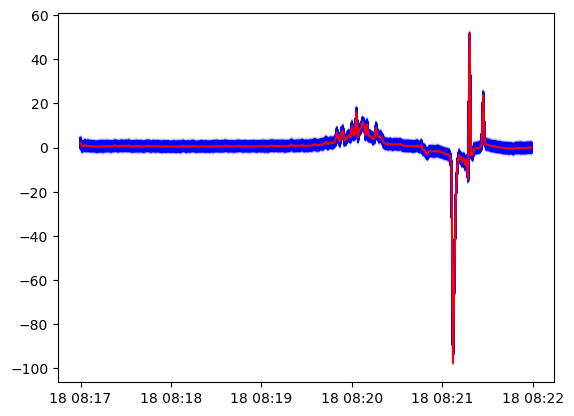

In [ ]:
plt.plot(time_array_b, trace["epsilon_p"].T, color="blue", alpha=0.01)
plt.plot(time_array_b, LHS[:, 0] / (-mu_0 * EMFA[:, 1]), color="red")

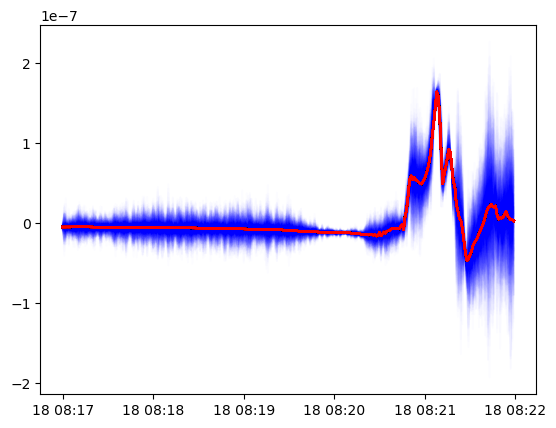

In [ ]:
for i in range(len(trace["epsilon_p"].T)):
    plt.plot(
        time_array_b,
        trace["epsilon_p"].T[:, i] * -mu_0 * EMFA[:, 1],
        color="blue",
        alpha=0.01,
    )
    plt.plot(time_array_b, LHS[:, 0], color="red")